## InSAR-HRRR-GPS Atmospheric Rivers
Date: July, 2021

- Time period: 2014-2019
- Objectives: visualization of InSAR, HRRR and GPS precipitable water data
- ARs: identified by integrated vapor transport (IVT) from MERRA2

In [392]:
import os
import sys
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
from datetime import datetime
import time
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings

from scipy.stats import linregress

In [9]:
warnings.filterwarnings('ignore')

In [2]:
# load data
date_ARs = xr.open_dataset('/data2/willytsai/InSAR_HRRR/date_ARs_events.nc') # identified evets
HRRR_ARs = xr.open_dataset('/data2/willytsai/InSAR_HRRR/HRRR_ARs/regrid_3km/merged/HRRR_pwat_ARs.nc') 

# stat_ARs = pd.DataFrame() # blank dataframe for merging
# pwv_ARs = pd.DataFrame()
# pifact_ARs = pd.DataFrame()

tmp1 = pd.read_pickle('/data2/willytsai/InSAR_HRRR/COSMIC_GPSPWV/2014/data_statInfo.pkl')
tmp2 = pd.read_pickle('/data2/willytsai/InSAR_HRRR/COSMIC_GPSPWV/2015/data_statInfo.pkl')
tmp3 = pd.read_pickle('/data2/willytsai/InSAR_HRRR/COSMIC_GPSPWV/2016/data_statInfo.pkl')
stat_ARs = pd.concat([tmp1,tmp2,tmp3])

tmp1 = pd.read_pickle('/data2/willytsai/InSAR_HRRR/COSMIC_GPSPWV/2014/data_pwv.pkl')
tmp2 = pd.read_pickle('/data2/willytsai/InSAR_HRRR/COSMIC_GPSPWV/2015/data_pwv.pkl')
tmp3 = pd.read_pickle('/data2/willytsai/InSAR_HRRR/COSMIC_GPSPWV/2016/data_pwv.pkl')
pwv_ARs = pd.concat([tmp1,tmp2,tmp3],axis=1)

In [3]:
date_datetime = datetime.utcfromtimestamp(date_ARs.time[-1].values.astype(int) * 1e-9)
pwv_exam = pwv_ARs.loc[date_datetime] # return pandas series

In [4]:
pwv_exam

1LSU     NaN
1ULM     NaN
ABMF     NaN
ABVI     NaN
ACU6     NaN
        ... 
FLCB    15.4
ZJX1    18.4
NMDE    14.1
SG33    12.3
SCUB    30.4
Name: 2016-12-16 15:00:00, Length: 1818, dtype: float32

In [5]:
pwv_hrrr = HRRR_ARs.sel(time=date_datetime,method='nearest')
pwv_hrrr

<xarray.Dataset>
Dimensions:    (latitude: 333, longitude: 267)
Coordinates:
    time       datetime64[ns] 2016-12-16T15:00:00
  * latitude   (latitude) float64 30.02 30.05 30.08 30.11 ... 39.92 39.95 39.98
  * longitude  (longitude) float64 -124.0 -124.0 -123.9 ... -116.1 -116.0 -116.0
Data variables:
    pwat       (latitude, longitude) float64 ...

In [6]:
# add MERRA2 data for double check
os.chdir('/data2/willytsai/InSAR_HRRR/MERRA2_ARs/')
files = sorted(glob('*.nc')) 
data_mega = xr.open_mfdataset('*.nc')
data_mega = data_mega.sel(time=date_datetime,lon=slice(-140,-110))

In [7]:
qv = data_mega.QV
qv = qv.fillna(0)
pa = data_mega.lev*100
pwv_M2 = -1/9.8*np.trapz(qv,pa,axis=0)

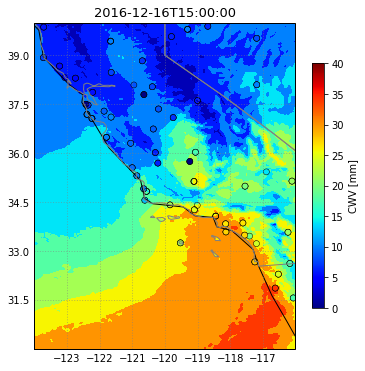

In [18]:
fig = plt.figure(figsize=(6,6))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lakes_shp',
    scale='50m',
    facecolor='none')

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')

plt.contourf(pwv_hrrr.longitude,pwv_hrrr.latitude,pwv_hrrr.pwat,levels=np.linspace(0,40,11)
            ,linewidth=1,cmap='jet')
#plt.contourf(data_mega.lon,data_mega.lat,pwv_M2,levels=np.linspace(0,30,11)
#           ,linewidth=1,cmap='jet')

plt.scatter(stat_ARs.lon,stat_ARs.lat,c=pwv_exam,cmap='jet',vmin=0,vmax=40,
           edgecolors='k',linewidths=0.5)
cbar = plt.colorbar(shrink=0.75)
cbar.set_label('CWV [mm]')
plt.xlim([-124,-116])
plt.ylim([30,40])
plt.xlabel('longitude')
plt.title(str(pwv_hrrr.time.values)[:-10],fontsize=13)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')
gl.xlabels_top=False; gl.ylabels_right=False

In [56]:
pwv_hrrr = HRRR_ARs.sel(time=date_datetime,method='nearest')
pwv_hrrr = pwv_hrrr.sel(latitude=slice(30,40),longitude=slice(-127,-110))
pwv_hrrr

<xarray.Dataset>
Dimensions:    (latitude: 333, longitude: 267)
Coordinates:
    time       datetime64[ns] 2014-12-11T15:00:00
  * latitude   (latitude) float64 30.02 30.05 30.08 30.11 ... 39.92 39.95 39.98
  * longitude  (longitude) float64 -124.0 -124.0 -123.9 ... -116.1 -116.0 -116.0
Data variables:
    pwat       (latitude, longitude) float64 ...

In [59]:
pwv_hrrr = HRRR_ARs.sel(time=date_datetime,method='nearest')
pwv_hrrr.sel(latitude=slice(30,40),longitude=slice(-127,-110))
pwv_hrrr

<xarray.Dataset>
Dimensions:    (latitude: 333, longitude: 267)
Coordinates:
    time       datetime64[ns] 2014-12-11T15:00:00
  * latitude   (latitude) float64 30.02 30.05 30.08 30.11 ... 39.92 39.95 39.98
  * longitude  (longitude) float64 -124.0 -124.0 -123.9 ... -116.1 -116.0 -116.0
Data variables:
    pwat       (latitude, longitude) float64 ...

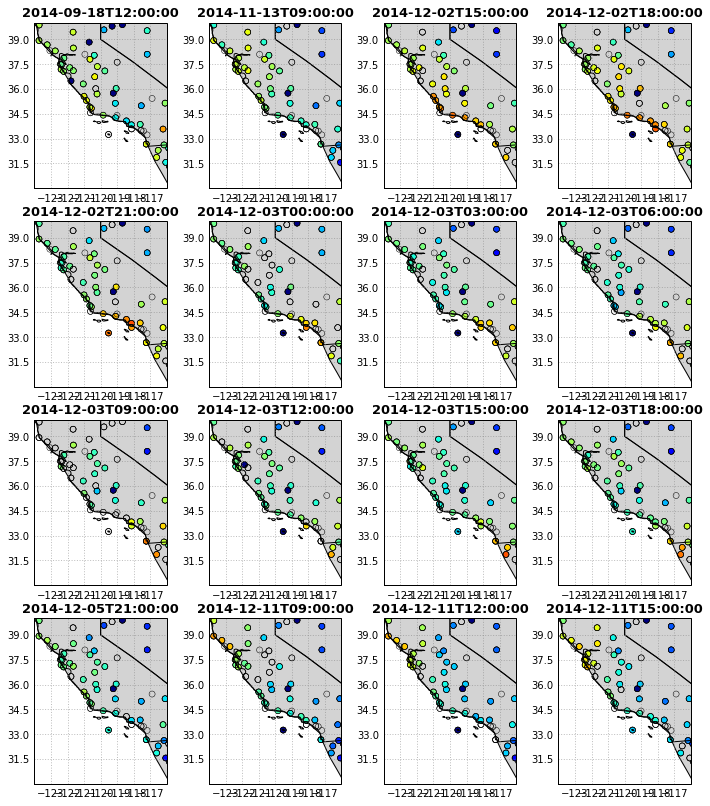

In [99]:
fig,ax = plt.subplots(4,4,figsize=(12,14)
                      ,subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
nrow = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
ncol = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]

for i in range(16):
    
    # extract data 
    date_datetime = datetime.utcfromtimestamp(date_ARs.time[20+i].values.astype(int) * 1e-9)
    pwv_exam = pwv_ARs.loc[date_datetime] 
    pwv_hrrr = HRRR_ARs.sel(time=date_datetime,method='nearest')
    pwv_hrrr = pwv_hrrr.sel(latitude=slice(30,40),longitude=slice(-124,-116))
    
    # plotting section below
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes_shp',
        scale='50m',
        facecolor='none')

    ax[nrow[i],ncol[i]].add_feature(cfeature.LAND, facecolor='lightgrey')
    ax[nrow[i],ncol[i]].add_feature(cfeature.COASTLINE, edgecolor='black')
    ax[nrow[i],ncol[i]].add_feature(states_provinces, edgecolor='black')
    
    # HRRR
#    ax[nrow[i],ncol[i]].contourf(pwv_hrrr.longitude,pwv_hrrr.latitude,pwv_hrrr.pwat.values,levels=np.linspace(0,50,11)
#           ,linewidth=1,cmap='jet')

    ax[nrow[i],ncol[i]].scatter(stat_ARs.lon,stat_ARs.lat,c=pwv_exam,cmap='jet',vmin=0,vmax=50,
           edgecolors='k',linewidths=0.5)
    ax[nrow[i],ncol[i]].set_title(str(pwv_hrrr.time.values)[:-10],fontsize=13,fontweight='bold')
    
    gl = ax[nrow[i],ncol[i]].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')
    gl.xlabels_top=False; gl.ylabels_right=False
    
    ax[nrow[i],ncol[i]].set_xlim([-124,-116])
    ax[nrow[i],ncol[i]].set_ylim([30,40])
    
plt.tight_layout()

In [84]:
# scatter plot HRRR and GPS 
axis_bound = [30,40,-124,-116]
staNam_bound = stat_ARs.loc[stat_ARs['lat'].between(axis_bound[0],axis_bound[1]) &
                            stat_ARs['lon'].between(axis_bound[2],axis_bound[3])]
#plt.scatter(0)

In [377]:
# extract data on specific time 
date_datetime = datetime.utcfromtimestamp(date_ARs.time[20].values.astype(int) * 1e-9)
pwv_GPS = pwv_ARs.loc[date_datetime] 
pwv_hrrr = HRRR_ARs.sel(time=date_datetime,method='nearest')

# determine the targeted region
stat_sub = stat_ARs.loc[stat_ARs['lat'].between(axis_bound[0],axis_bound[1]) &
                           stat_ARs['lon'].between(axis_bound[2],axis_bound[3])] # stations in the bounded region
stat_sub = stat_sub.drop_duplicates(keep=False)
pwv_hrrr = pwv_hrrr.sel(latitude=slice(axis_bound[0],axis_bound[1])
                        ,longitude=slice(axis_bound[2],axis_bound[3]))

# pwv from stations and hrrr
lon_list = []; lat_list = []; pwv_GPS_sub = []; pwv_hrrr_GPS = []
for stat in stat_sub.index:
        lon_gps = stat_sub.loc[stat]['lon']
        lat_gps = stat_sub.loc[stat]['lat']
        
        if type(pwv_GPS.loc[stat]).__module__ == 'numpy':

            pwv_GPS_sub.append(pwv_GPS.loc[stat])
            pwv_hrrr_GPS.append(pwv_hrrr.sel(longitude=lon_gps,latitude=lat_gps,method='nearest').pwat.mean().values)
            lon_list.append(lon_gps)
            lat_list.append(lat_gps)

        else:
        
            pwv_GPS_sub.append(pwv_GPS.loc[stat].iloc[0])
            pwv_hrrr_GPS.append(pwv_hrrr.sel(longitude=lon_gps,latitude=lat_gps,method='nearest').pwat.mean().values)
            lon_list.append(lon_gps)
            lat_list.append(lat_gps)
        
# merge infor into a dataframe
pwv_pointwise = pd.DataFrame({'lon': np.array(lon_list),
                      'lat': np.array(lat_list),
                      'hrrr': np.array(pwv_hrrr_GPS),
                      'GPS': np.array(pwv_GPS_sub)})

In [378]:
pwv_pointwise

,lon,lat,hrrr,GPS
0,-116.889251,35.425156,21.592876,NaN
1,-119.109481,35.132388,18.217876,17.700001
2,-117.403984,33.455351,23.592876,NaN
3,-121.664887,39.432880,30.717876,29.700001
4,-117.608922,33.857633,25.467876,21.500000
5,-118.128788,33.583499,24.592876,NaN
6,-118.137186,33.832071,23.342876,18.200001
7,-117.186533,39.521138,23.092876,20.299999
8,-119.062871,36.027437,19.967876,21.299999
9,-123.726200,38.928347,31.967876,28.299999


In [398]:
reg_stats

LinregressResult(slope=0.987686568569973, intercept=-1.075184892446316, rvalue=0.8857502465153414, pvalue=3.107383502075542e-14, stderr=0.083962582903536)

(12.899999618530273, 39.0)

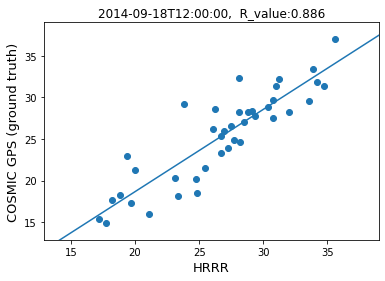

In [406]:
pwv_pointwise = pwv_pointwise.replace(-9.9,np.nan).dropna(how='any') # remove nan and -9.9

plt.scatter(pwv_pointwise['hrrr'],pwv_pointwise['GPS'])
plt.xlabel('HRRR',fontsize=13);plt.ylabel('COSMIC GPS (ground truth)',fontsize=13)
min_x,max_x = pwv_pointwise['hrrr'].min(), pwv_pointwise['hrrr'].max()
min_y,max_y = pwv_pointwise['GPS'].min(), pwv_pointwise['GPS'].max()

# linear regression
reg_stats = linregress(pwv_pointwise['hrrr'],pwv_pointwise['GPS'])
plt.plot(np.linspace(min(min_x,min_y)-2,max(max_x,max_y)+2),
        reg_stats.slope*np.linspace(min(min_x,min_y)-2,max(max_x,max_y)+2)+reg_stats.intercept)
plt.title(str(pwv_hrrr.time.values)[:-10] + ',  R_value:'+str(np.round(reg_stats.rvalue,3)))
plt.xlim([min(min_x,min_y)-2, max(max_x,max_y)+2])
plt.ylim([min(min_x,min_y)-2, max(max_x,max_y)+2])

In [405]:
reg_stats.slope

0.987686568569973

In [98]:
staNam_bound.loc['BKR1']['lon'][0]

-119.10947865319605